## Imports and functions

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydicom as dicom 
import os
import SimpleITK as sitk
import math

from skimage import io, color
from skimage.util import img_as_float,img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, disk
from skimage.transform import rescale, resize, rotate, EuclideanTransform, warp, AffineTransform, SimilarityTransform, swirl, matrix_transform
from skimage.filters import threshold_otsu, median, gaussian, prewitt_h,prewitt_v, prewitt
from skimage import measure
from skimage.color import label2rgb

from scipy.stats import norm
from scipy.spatial import distance

from sklearn import decomposition
from sklearn.decomposition import PCA

## Exam 2022 - Abdominal analysis
There is a growing interest in the functions of the kidneys and how the shape of the
kidneys relates to diseases. You have been asked to help analyzing kidneys as seen on
computed tomography (CT) scans of the human abdominal area.
You have been given a slice of a CT scan as a DICOM file (1-162.dcm) and expert
annotations of background (BackROI.png, LiverROI.png, KidneyROI.png and the
AortaROI.png).
Your first algorithm works like this:
1. Reads the DICOM image
2. Uses the annotated regions to extract pixel values in the liver, kidney and aorta regions
3. Determines two threshold using minimum distance classification. Threshold number (t1) separates the liver and the kidney. The second threshold (t2) separates the kidney and the aorta.
4. Segments the DICOM image by setting all pixel that have a value >t1 and <t2 to foreground and the rest to background.
5. Computes the DICE score between the resulting segmented image and the KidneyROI.png image.

You have tested the algorithm on the 1-162.dcm image.


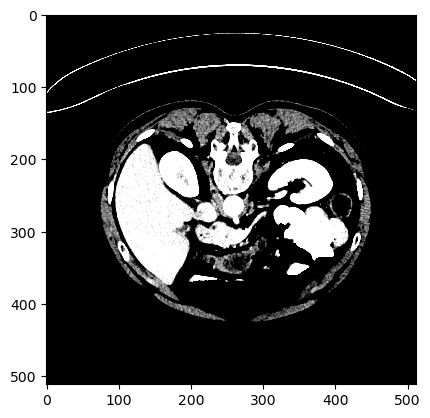

In [4]:
in_dir = "data02/"
scan = dicom.read_file(in_dir + '1-162.dcm')
img = scan.pixel_array
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.show()

In [5]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf


paths = ['AortaROI.png','KidneyROI.png','BackROI.png', 'LiverROI.png']
values = [get_values(img, in_dir + path) for path in paths]

In [15]:
min_hu = np.min(img)
max_hu = np.max(img)

class_sorted = []
mean_classes = [np.mean(i) for i in values]
for i in range(len(paths)):
      class_sorted.append((paths[i], mean_classes[i]))
class_sorted.sort(key=lambda x: x[1])

midway_points = [(class_sorted[i][1] + class_sorted[i+1][1]) / 2 for i in range(len(class_sorted) - 1)]
print('Class: ',[i[0] for i in class_sorted])
print('Midway point:',midway_points)

print('')
ranges = [min_hu] + midway_points + [max_hu]
for i in range(len(midway_points)+1):
    print(class_sorted[i][0][:-7], 'is in the range [', ranges[i], ',', ranges[i+1], ']')
    
t_1 = midway_points[1]
t_2 = midway_points[2]
print('\nt_1 = ', t_1)
print('t_2 = ', t_2)


Class:  ['BackROI.png', 'LiverROI.png', 'KidneyROI.png', 'AortaROI.png']
Midway point: [-439.32068354728085, 135.53619417264818, 196.7035801627044]

Back is in the range [ -1024 , -439.32068354728085 ]
Liver is in the range [ -439.32068354728085 , 135.53619417264818 ]
Kidney is in the range [ 135.53619417264818 , 196.7035801627044 ]
Aorta is in the range [ 196.7035801627044 , 1140 ]

t_1 =  135.53619417264818
t_2 =  196.7035801627044


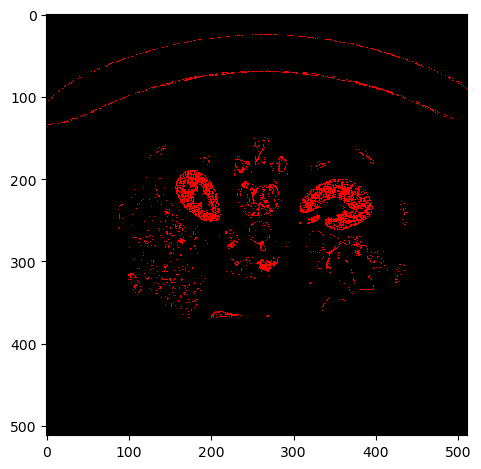

In [17]:
estimate = (img > t_1) & (img < t_2)
label_colour = color.label2rgb(estimate)
io.imshow(label_colour)
io.show()

In [19]:
ground_truth_img = io.imread(in_dir + 'KidneyROI.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(estimate.ravel(), gt_bin.ravel())
dice_score

0.24143337066069426

### Abdominal CT analysis

In collaboration with a hospital, you want to investigate how the kidneys and the livers are related to the overall health status of a person. You do that by analyzing the appearance of the kidneys and the livers as seen computed tomography (CT) scans of the human abdominal area.

To test the approach, you use it on slice of a CT scan. It is a DICOM file called 1-166.dcm. You have also been given expert annotations of the liver (LiverROI.png), the left kidney (KidneyRoi_l.png) and the right kidney (KidneyRoi_r.png).

Your analysis pipeline consists of the following steps: 

- Read the DICOM file and the expert annotations
- Extract the pixel values of the liver, the left and the right kidney using the expert annotations
- Compute the average Hounsfield unit value in the left and the right kidney (too see if there is a functional difference)
- Compute the average and the standard deviation of the Hounsfield units in the liver
- Compute a threshold for the liver, t_1, that is the average liver Hounsfield unit minus the standard deviation
- Compute a threshold for the liver, t_2, that is the average liver Hounsfield unit plus the standard deviation
- Create a binary image by setting all pixels that have a  value that is between t_1 and t_2 to 1 and the rest to background.
- Dilate the binary image with a disk shaped kernel with radius=3
- Erode the binary image with a disk shaped kernel with radius=10
- Dilate the binary image with a disk shaped kernel with radius=10
- Extract all BLOBs in the binary image
- Compute the area and the perimeter of all BLOBs
- Remove all BLOBs with an area<1500 or an area>7000 or a perimeter<300
- Compute the DICE score between the estimated liver and the ground truth liver (LiverROI.png)
 

1. Read the DICOM file and the expert annotations

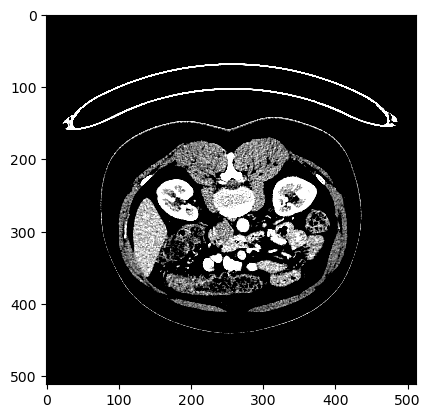

In [42]:
in_dir = "data/"
scan = dicom.read_file(in_dir + '1-166.dcm')
img = scan.pixel_array
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.show()


In [ ]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf


paths = ['KidneyRoi_l.png', 'KidneyRoi_r.png', 'LiverROI.png']

2. Extract the pixel values of the liver, the left and the right kidney using the expert annotations

In [ ]:
values = [get_values(img, in_dir + path) for path in paths]

3. Compute the average Hounsfield unit value in the left and the right kidney (too see if there is a functional difference)

In [ ]:
average_hou_kidney_l = np.mean(values[0])
average_hou_kidney_r = np.mean(values[1])
print("Average HU for left kidney: ", average_hou_kidney_l)
print("Average HU for right kidney: ", average_hou_kidney_r)    

Average HU for left kidney:  107.45075421472937
Average HU for right kidney:  107.56182572614108


4. Compute the average and the standard deviation of the Hounsfield units in the liver
5. Compute a threshold for the liver, t_1, that is the average liver Hounsfield unit minus the standard deviation
6. Compute a threshold for the liver, t_2, that is the average liver Hounsfield unit plus the standard deviation

In [ ]:
mu_liver = np.mean(values[2])
std_liver = np.std(values[2])
t_1 = mu_liver - std_liver
t_2 = mu_liver + std_liver
print("T1: ", t_1)
print("T2: ", t_2)

T1:  51.7968823111612
T2:  100.87099317992372


7. Create a binary image by setting all pixels that have a  value that is between t_1 and t_2 to 1 and the rest to background.

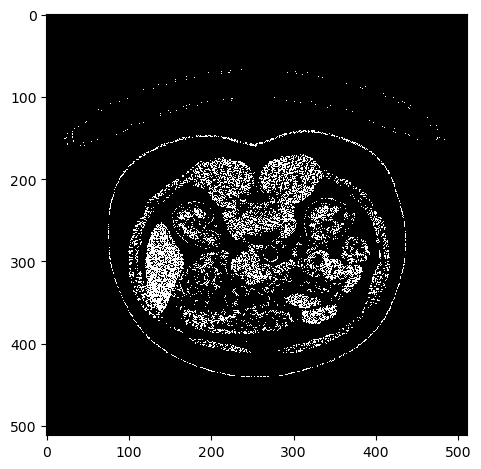

In [ ]:
liver_thres = np.logical_and(img > t_1, img < t_2)
io.imshow(liver_thres)

8. Dilate the binary image with a disk shaped kernel with radius=3
9. Erode the binary image with a disk shaped kernel with radius=10
10. Dilate the binary image with a disk shaped kernel with radius=10
11. Extract all BLOBs in the binary image
12. Compute the area and the perimeter of all BLOBs
13. Remove all BLOBs with an area<1500 or an area>7000 or a perimeter<300
14. Compute the DICE score between the estimated liver and the ground truth liver (LiverROI.png)

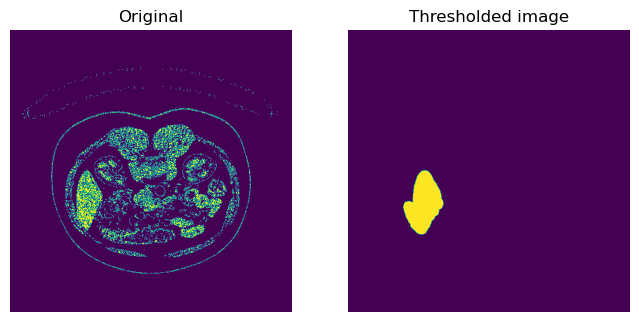

In [ ]:
bin_img = liver_thres
footprint = disk(3)
dilated = dilation(bin_img, footprint)
footprint = disk(10)
eroded = erosion(dilated, footprint)
dilated = dilation(eroded, footprint)

min_area = 1500
max_area = 7000
min_peri = 300

label_img = measure.label(dilated)
region_props = measure.regionprops(label_img)
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area or region.perimeter < min_peri:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(liver_thres, i_area, 'Thresholded image')

In [ ]:
def DICE_score(i_area, ground_truth_img):
    i_area = i_area
    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
    return dice_score

ground_truth_img = io.imread(in_dir + 'LiverROI.png')
dice_score = DICE_score(i_area, ground_truth_img)
dice_score

0.782588123964987